# California Housing Price Model

### Big picture

Use CA census data to build a model of housing prices in the state. The data includes metrics such as the population, median income, and median housing price for each 'block group'. Block groups are the smallest geographical unit that the US Census Bureau publishes sample data - referred to as districts in this script. The primary goal of this model is to predict median housing price in any district.

*What is the business objective?* Output from this model will be fed into another ML system, along with additional signals, which will determine whether an area is worth investment.



In [25]:
from packaging import version
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

### Get the data

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

C:\Users\Paul.Carvalho\AppData\Local\Temp\ipykernel_19704\2839428726.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

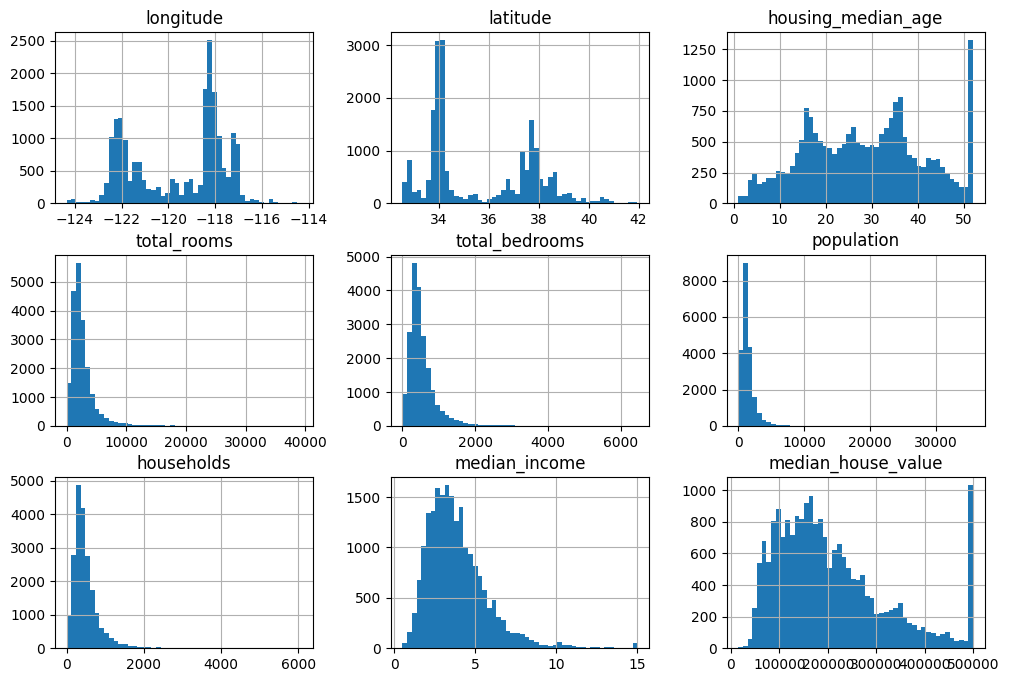

In [10]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

From these histograms we see:
1. Median income is not in USD. Data are scaled and restricted to 0.5 and 15. These values represent tens of thousands of dollars.
2. Housing median age and value were also capped.
3. The attributes have very different scales - suggest feature scaling is warranted.
4. Many of the histograms are skewed right.

### Create a test set

In [26]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Exlpore data

In [27]:
housing = train_set.copy()

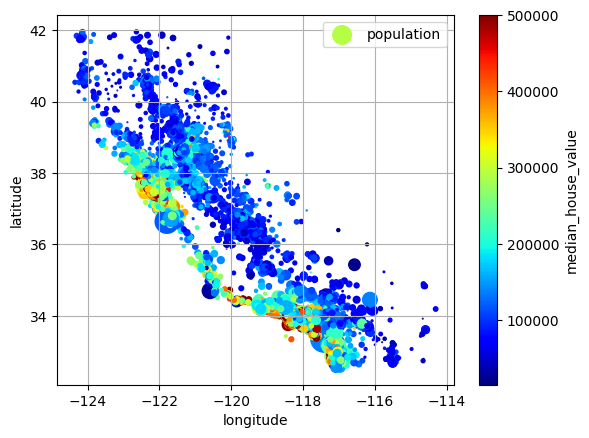

In [39]:
housing.plot(kind="scatter", x='longitude', y='latitude', grid=True,
             s=housing['population']/100, label="population",
             c='median_house_value', cmap='jet', colorbar=True,
             legend=True, sharex=False)
plt.show()

AttributeError: AxesImage.set() got an unexpected keyword argument 'colorbar'

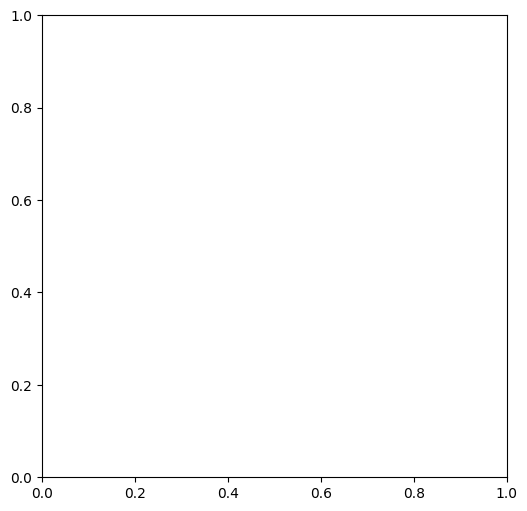

In [ ]:
corr_mat = housing.corr(numeric_only=True)
plt.figure(figsize=(6,6))
plt.imshow(corr_mat, cmap='viridis'),
plt.xticks(ticks=range(corr_mat.shape[0]),
           labels=corr_mat.columns,
           rotation=45)
plt.yticks(ticks=range(corr_mat.shape[0]),
           labels=corr_mat.columns)
plt.show()

array([[ 1.00000000e+00, -9.24340663e-01, -1.10786185e-01,
         4.31003894e-02,  6.94388939e-02,  1.00706416e-01,
         5.63184552e-02, -1.45924536e-02, -4.36033123e-02],
       [-9.24340663e-01,  1.00000000e+00,  1.26404011e-02,
        -3.63274014e-02, -6.92827898e-02, -1.10514472e-01,
        -7.39148197e-02, -7.92585653e-02, -1.46323507e-01],
       [-1.10786185e-01,  1.26404011e-02,  1.00000000e+00,
        -3.62432589e-01, -3.18544318e-01, -2.91842022e-01,
        -3.01197503e-01, -1.18410013e-01,  1.04713680e-01],
       [ 4.31003894e-02, -3.63274014e-02, -3.62432589e-01,
         1.00000000e+00,  9.28198936e-01,  8.51766332e-01,
         9.16264648e-01,  1.97326117e-01,  1.34060450e-01],
       [ 6.94388939e-02, -6.92827898e-02, -3.18544318e-01,
         9.28198936e-01,  1.00000000e+00,  8.73483999e-01,
         9.79626872e-01, -1.17823396e-02,  4.99927839e-02],
       [ 1.00706416e-01, -1.10514472e-01, -2.91842022e-01,
         8.51766332e-01,  8.73483999e-01,  1.000000